In [6]:
# import pandas as pd
# import numpy as np
# ! conda install faiss-cpu -c pytorch
# import faiss

# def get_kmeans_label(feed_emb_path, save_path, num):
#     feed_emb = pd.read_csv(feed_emb_path)
#     feed_emb['feed_embedding'] = feed_emb['feed_embedding'].apply(
#         lambda x: np.array(x.strip().split(' '), dtype='float32'))
#     feed_embedding = np.array([i for i in feed_emb['feed_embedding'].values])
#     del feed_emb['feed_embedding']
#     km = faiss.Kmeans(512, num, niter=500, verbose=True, gpu=False)
#     km.train(feed_embedding)
#     print('train finished.')
#     _, labels = km.index.search(feed_embedding, 1)
#     feed_emb['km_label'] = labels
#     feed_emb.to_csv(save_path, index=False)

In [124]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error, log_loss
pd.options.display.precision = 15
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
import time
import datetime
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import json
%matplotlib inline

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [175]:
out_path = './output/'
train_path = './data/original_train.csv'
test_path = './data/original_test_A.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [126]:
train.head()

,CUST_UID,LABEL,AGN_CNT_RCT_12_MON,ICO_CUR_MON_ACM_TRX_TM,NB_RCT_3_MON_LGN_TMS_AGV,AGN_CUR_YEAR_AMT,AGN_CUR_YEAR_WAG_AMT,AGN_AGR_LATEST_AGN_AMT,ICO_CUR_MON_ACM_TRX_AMT,COUNTER_CUR_YEAR_CNT_AMT,...,WTHR_OPN_ONL_ICO,EMP_NBR,REG_CPT,SHH_BCK,HLD_DMS_CCY_ACT_NBR,REG_DT,LGP_HLD_CARD_LVL,OPN_TM,NB_CTC_HLD_IDV_AIO_CARD_SITU,HLD_FGN_CCY_ACT_NBR
0,2a171d461bf24a739b804c2843ad4f6e,0,NaN,72.0,425.300000000000011,NaN,NaN,NaN,2.587998530000000e+07,2.0,...,B,2.0,1200000002.0,32.0,12.0,1708.450000000000045,NaN,416.839999999999975,NaN,2.0
1,c58d5848d18548e297963c2d9e092699,0,2282.0,222.0,NaN,1.177657240000000e+07,NaN,1.964626400000000e+06,1.475549980000000e+07,2.0,...,B,1002.0,5000002.0,32.0,22.0,199.419999999999987,F,195.870000000000005,D,2.0
2,74e6d8179e784a039bcb5a722014f4a4,0,NaN,2.0,NaN,NaN,NaN,4.599822300000000e+06,2.000000000000000e+00,2.0,...,B,2.0,NaN,2.0,12.0,1135.549999999999955,F,1122.000000000000000,NaN,2.0
3,1b6a8be2c2e34de09ca00d71470ec180,1,NaN,NaN,22.000000000000000,NaN,NaN,NaN,NaN,2.0,...,A,2.0,500002.0,12.0,12.0,98.450000000000003,NaN,92.000000000000000,C,2.0
4,1974b5e0440a41128a416a8cdc8a7c16,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,A,2.0,NaN,2.0,12.0,NaN,NaN,355.870000000000005,C,2.0


In [ ]:
corr_fea = train[list(train.columns)].corr()
#list(corr_fea['AGN_CUR_YEAR_WAG_AMT'][corr_fea['AGN_CUR_YEAR_WAG_AMT'] > 0.3].index)
from tqdm import tqdm
cat_cols = ['MON_12_CUST_CNT_PTY_ID','AI_STAR_SCO','WTHR_OPN_ONL_ICO',
'SHH_BCK','LGP_HLD_CARD_LVL','NB_CTC_HLD_IDV_AIO_CARD_SITU'] #'COR_KEY_PROD_HLD_NBR',
history_data = []
very_low_corr_fea = []
print(len(list(corr_fea.columns)[2:]))
for col1 in tqdm(list(train.columns)[2:]):
    if col1 in cat_cols: continue
    # if len(list(corr_fea[col1][corr_fea[col1] > 0.3].index)) <2:
    #     very_low_corr_fea.append(col1)
    #print(len(list(corr_fea[col1][corr_fea[col1] > 0.3].index)))
    for col2 in list(corr_fea[col1][corr_fea[col1] > 0.3].index):
        
        if col1 == col2 or sorted([col1,col2]) in history_data: continue
        history_data.append(sorted([col1,col2]))
        train[f'corr_{col1}_{col2}_diff'] = train[col1] - train[col2]
        train[f'corr_{col1}_{col2}_rate'] = train[col1]/train[col2]
        test[f'corr_{col1}_{col2}_diff'] = test[col1] - test[col2]
        test[f'corr_{col1}_{col2}_rate'] = test[col1]/test[col2]
print(len(history_data))
    

In [180]:
# IN/OUT类，enter/lve 类
train['MON_12_ACT_50_UP_CNT_PTY_QTY_RATE'] = train['MON_12_ACT_IN_50_UP_CNT_PTY_QTY']/train['MON_12_ACT_OUT_50_UP_CNT_PTY_QTY']
train['MON_12_EXT_SAM_TRSF_AMT_RATE'] = train['MON_12_EXT_SAM_TRSF_IN_AMT']/train['MON_12_EXT_SAM_TRSF_OUT_AMT']
train['CUR_MON_EXT_SAM_CUST_TRSF_AMT_RATE'] = train['CUR_MON_EXT_SAM_CUST_TRSF_IN_AMT']/train['CUR_MON_EXT_SAM_CUST_TRSF_OUT_AMT']

train['MON_6_50_UP_ACT_CNT_RATE'] = train['MON_6_50_UP_ENTR_ACT_CNT']/train['MON_6_50_UP_LVE_ACT_CNT']
train['MON_12_ACM_ACT_CNT_RATE'] = train['MON_12_ACM_ENTR_ACT_CNT']/train['MON_12_ACM_LVE_ACT_CNT']
train['MON_12_AGV_ACT_CNT_RATE'] = train['MON_12_AGV_ENTR_ACT_CNT']/train['MON_12_AGV_LVE_ACT_CNT']


test['MON_12_ACT_50_UP_CNT_PTY_QTY_RATE'] = test['MON_12_ACT_IN_50_UP_CNT_PTY_QTY']/test['MON_12_ACT_OUT_50_UP_CNT_PTY_QTY']
test['MON_12_EXT_SAM_TRSF_AMT_RATE'] = test['MON_12_EXT_SAM_TRSF_IN_AMT']/test['MON_12_EXT_SAM_TRSF_OUT_AMT']
test['CUR_MON_EXT_SAM_CUST_TRSF_AMT_RATE'] = test['CUR_MON_EXT_SAM_CUST_TRSF_IN_AMT']/test['CUR_MON_EXT_SAM_CUST_TRSF_OUT_AMT']

test['MON_6_50_UP_ACT_CNT_RATE'] = test['MON_6_50_UP_ENTR_ACT_CNT']/test['MON_6_50_UP_LVE_ACT_CNT']
test['MON_12_ACM_ACT_CNT_RATE'] = test['MON_12_ACM_ENTR_ACT_CNT']/test['MON_12_ACM_LVE_ACT_CNT']
test['MON_12_AGV_ACT_CNT_RATE'] = test['MON_12_AGV_ENTR_ACT_CNT']/test['MON_12_AGV_LVE_ACT_CNT']


train[['MON_12_ACT_50_UP_CNT_PTY_QTY_RATE','MON_12_EXT_SAM_TRSF_AMT_RATE','CUR_MON_EXT_SAM_CUST_TRSF_AMT_RATE',
'MON_6_50_UP_ACT_CNT_RATE','MON_12_ACM_ACT_CNT_RATE','MON_12_AGV_ACT_CNT_RATE']].describe()

,MON_12_ACT_50_UP_CNT_PTY_QTY_RATE,MON_12_EXT_SAM_TRSF_AMT_RATE,CUR_MON_EXT_SAM_CUST_TRSF_AMT_RATE,MON_6_50_UP_ACT_CNT_RATE,MON_12_ACM_ACT_CNT_RATE,MON_12_AGV_ACT_CNT_RATE
count,34140.000000000000000,3.974600000000000e+04,3.905400000000000e+04,33380.000000000000000,39746.000000000000000,39746.000000000000000
mean,2.672492518252018,1.864020440577734e+07,6.239016346871228e+06,2.390134484266595,3.187788213318806,1.668836996811980
std,12.836292123007981,3.961890872490261e+08,1.115203790795227e+08,8.741367029362955,88.980043940457449,12.655609197179112
min,0.004739336492891,5.463452785621355e-12,3.610882296390756e-11,0.002463054187192,0.000058856262306,0.000118775520686
25%,0.583333333333333,8.367693923838755e-01,1.000000000000000e+00,0.653465346534653,0.224005711601621,0.249254583534786
50%,1.000000000000000,1.000000000000000e+00,1.000000000000000e+00,1.000000000000000,0.503932558205470,0.534213147204556
75%,1.937500000000000,1.092392895191128e+00,1.000000000000000e+00,1.688995425756509,1.065789473684211,1.063209095171120
max,1036.000000000000000,4.190000000100000e+10,1.130800000100000e+10,916.000000000000000,14126.000000000000000,1178.099999999999909


In [181]:
# —和WAG类
train['AGN_CUR_YEAR_AMT_RATE'] = train['AGN_CUR_YEAR_AMT']/train['AGN_CUR_YEAR_WAG_AMT']
train['AGN_CUR_YEAR_AMT_diff'] = train['AGN_CUR_YEAR_AMT']-train['AGN_CUR_YEAR_WAG_AMT']#注意diff类特征存在负数

test['AGN_CUR_YEAR_AMT_RATE'] = test['AGN_CUR_YEAR_AMT']/test['AGN_CUR_YEAR_WAG_AMT']
test['AGN_CUR_YEAR_AMT_diff'] = test['AGN_CUR_YEAR_AMT']-test['AGN_CUR_YEAR_WAG_AMT']#注意diff类特征存在负数
train[['AGN_CUR_YEAR_AMT_RATE','AGN_CUR_YEAR_AMT_diff']].describe()


,AGN_CUR_YEAR_AMT_RATE,AGN_CUR_YEAR_AMT_diff
count,1.201500000000000e+04,1.201500000000000e+04
mean,2.507241976111789e+04,1.881541751173533e+07
std,2.360544717776509e+06,5.490308863724020e+08
min,3.842437968049928e-04,-1.777642288120000e+10
25%,1.000000000000000e+00,0.000000000000000e+00
50%,1.000000000000000e+00,0.000000000000000e+00
75%,1.059801838623570e+00,9.487881499999999e+05
max,2.561746020952381e+08,5.020919772890000e+10


In [129]:
#ACM和AGV类


In [182]:
# TM和AMT
train['ICO_CUR_MON_ACM_TRX_TM_RATE'] = train['ICO_CUR_MON_ACM_TRX_AMT']/train['ICO_CUR_MON_ACM_TRX_TM']
train['ICO_CUR_MON_ACM_TRX_TM_diff'] = train['ICO_CUR_MON_ACM_TRX_TM']-train['ICO_CUR_MON_ACM_TRX_AMT']
train[['ICO_CUR_MON_ACM_TRX_TM_RATE','ICO_CUR_MON_ACM_TRX_TM_diff']].describe()

train['MON_12_EXT_SAM_AMT_RATE'] = train['MON_12_EXT_SAM_AMT']/train['MON_12_EXT_SAM_NM_TRSF_OUT_CNT']
train['MON_12_EXT_SAM_AMT_diff'] = train['MON_12_EXT_SAM_AMT']-train['MON_12_EXT_SAM_NM_TRSF_OUT_CNT']

test['ICO_CUR_MON_ACM_TRX_TM_RATE'] = test['ICO_CUR_MON_ACM_TRX_AMT']/test['ICO_CUR_MON_ACM_TRX_TM']
test['ICO_CUR_MON_ACM_TRX_TM_diff'] = test['ICO_CUR_MON_ACM_TRX_TM']-test['ICO_CUR_MON_ACM_TRX_AMT']

test['MON_12_EXT_SAM_AMT_RATE'] = test['MON_12_EXT_SAM_AMT']/test['MON_12_EXT_SAM_NM_TRSF_OUT_CNT']
test['MON_12_EXT_SAM_AMT_diff'] = test['MON_12_EXT_SAM_AMT']-test['MON_12_EXT_SAM_NM_TRSF_OUT_CNT']

train[['MON_12_EXT_SAM_AMT_RATE','MON_12_EXT_SAM_AMT_diff']].describe()

,ICO_CUR_MON_ACM_TRX_TM_RATE,ICO_CUR_MON_ACM_TRX_TM_diff
count,3.649700000000000e+04,3.649700000000000e+04
mean,2.369392504775928e+06,-4.502267779649150e+08
std,3.236472743891037e+07,1.239699287792193e+10
min,1.727272727272727e-01,-1.965073126685500e+12
25%,1.139796228323700e+04,-5.874473340000000e+07
50%,5.872715714285714e+04,-9.622920000000000e+06
75%,2.773516738095238e+05,-8.495189000000000e+05
max,4.165833333500000e+09,3.160000000000000e+01


,MON_12_EXT_SAM_AMT_RATE,MON_12_EXT_SAM_AMT_diff
count,3.974600000000000e+04,3.974600000000000e+04
mean,2.038673162214002e+07,6.032425466708852e+07
std,4.010048521996185e+08,1.252842700683668e+10
min,-1.730878906187500e+09,-8.928800006801000e+11
25%,-4.641197646103896e+03,-1.200200000000000e+05
50%,1.000000000000000e+00,0.000000000000000e+00
75%,8.330660123966942e+03,4.904945000000000e+04
max,4.190000000100000e+10,1.640848562473800e+12


In [183]:
# 其他不明晰的成对特征


train['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate'] = train['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL']/train['CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR']
print(train[['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate']].describe())

train['LAST_12_MON_COR_DPS_DAY_AVG_BAL_rate'] = train['LAST_12_MON_COR_DPS_DAY_AVG_BAL']/train['LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL']
train['LAST_12_MON_COR_DPS_DAY_AVG_BAL_diff'] = train['LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL'] - train['LAST_12_MON_COR_DPS_DAY_AVG_BAL']
print(train[['LAST_12_MON_COR_DPS_DAY_AVG_BAL_rate', 'LAST_12_MON_COR_DPS_DAY_AVG_BAL_diff']].describe())


train['LAST_12_MON_MON_AVG_TRX_AMT_NAV_rate'] = train['LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV']/train['LAST_12_MON_MON_AVG_TRX_AMT_NAV']
print(train[['LAST_12_MON_MON_AVG_TRX_AMT_NAV_rate']].describe())

train['AGN_CNT_RCT_12_MON_rate'] = train['AGN_CNT_RCT_12_MON']/train['AGN_AGR_LATEST_AGN_AMT']
print(train[['AGN_CNT_RCT_12_MON_rate']].describe())

# train['MON_12_TRX_AMT_MAX_AMT_PCTT_rate'] = train['MON_12_CUST_CNT_PTY_ID']/train['MON_12_TRX_AMT_MAX_AMT_PCTT']
# print(train[['MON_12_TRX_AMT_MAX_AMT_PCTT_rate']].describe())

train['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate'] = train['CUR_MON_COR_DPS_MON_DAY_AVG_BAL']/train['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL']
print(train[['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate']].describe())

train['LAST_12_MON_MON_AVG_TRX_AMT_NAV_rate'] = train['LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV']/train['LAST_12_MON_MON_AVG_TRX_AMT_NAV']
print(train[['LAST_12_MON_MON_AVG_TRX_AMT_NAV_rate']].describe())


#####
test['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate'] = test['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL']/test['CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR']

test['LAST_12_MON_COR_DPS_DAY_AVG_BAL_rate'] = test['LAST_12_MON_COR_DPS_DAY_AVG_BAL']/test['LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL']
test['LAST_12_MON_COR_DPS_DAY_AVG_BAL_diff'] = test['LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL'] - test['LAST_12_MON_COR_DPS_DAY_AVG_BAL']


test['LAST_12_MON_MON_AVG_TRX_AMT_NAV_rate'] = test['LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV']/test['LAST_12_MON_MON_AVG_TRX_AMT_NAV']

test['AGN_CNT_RCT_12_MON_rate'] = test['AGN_CNT_RCT_12_MON']/test['AGN_AGR_LATEST_AGN_AMT']

#test['MON_12_TRX_AMT_MAX_AMT_PCTT_rate'] = test['MON_12_CUST_CNT_PTY_ID']/test['MON_12_TRX_AMT_MAX_AMT_PCTT']

test['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate'] = test['CUR_MON_COR_DPS_MON_DAY_AVG_BAL']/test['CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL']

test['LAST_12_MON_MON_AVG_TRX_AMT_NAV_rate'] = test['LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV']/test['LAST_12_MON_MON_AVG_TRX_AMT_NAV']



       CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL_rate
count                   39789.000000000000000
mean                      -14.293145676976014
std                      3521.522927107062969
min                   -699227.217054263572209
25%                        -0.632674418107018
50%                         1.113982917798210
75%                         2.259591374623909
max                     24482.487629688748711
       LAST_12_MON_COR_DPS_DAY_AVG_BAL_rate  \
count                 39885.000000000000000   
mean                      0.335923957048747   
std                       0.261018958118043   
min                       0.000001494394655   
25%                       0.132001714471098   
50%                       0.284219028571062   
75%                       0.487460842938715   
max                      10.811784865521476   

       LAST_12_MON_COR_DPS_DAY_AVG_BAL_diff  
count                 3.988500000000000e+04  
mean                  3.786315252407171e+08  
std                   3.

In [184]:
print(len(train.columns))
train.to_csv('./data/train_fea_gen.csv',index=None)
test.to_csv('./data/test_A_fea_gen.csv',index=None)


332


In [133]:
len(train.columns)

68

In [134]:
# FM 二阶交叉
# 调参
# 因子分析
# 替换nan为均值，中值，0
# 10折
# 相似度计算

# onehot效果似乎不太行
# cat_cols = ['MON_12_CUST_CNT_PTY_ID','AI_STAR_SCO','WTHR_OPN_ONL_ICO',
# 'SHH_BCK','LGP_HLD_CARD_LVL','NB_CTC_HLD_IDV_AIO_CARD_SITU'] #'COR_KEY_PROD_HLD_NBR',
# #train = train.merge(pd.get_dummies(test['R'], prefix='R'), left_index=True, right_index=True)#.drop(['R'], axis=1)
# #for col in cat_cols:
# train = train.merge(pd.get_dummies(train[cat_cols]), left_index=True, right_index=True)#.drop(cat_cols, axis=1)
# len(train.columns)
# test = test.merge(pd.get_dummies(test[cat_cols]), left_index=True, right_index=True)#.drop(cat_cols, axis=1)
# len(train.columns)
# train.head()

In [ ]:
# 张二勇华中科技大学(478721763)  16:27:19
# 我还行

# 张二勇华中科技大学(478721763)  16:27:23
# 我用的rf

# 张二勇华中科技大学(478721763)  16:27:39
# 删了最后十个，上升了0.0005



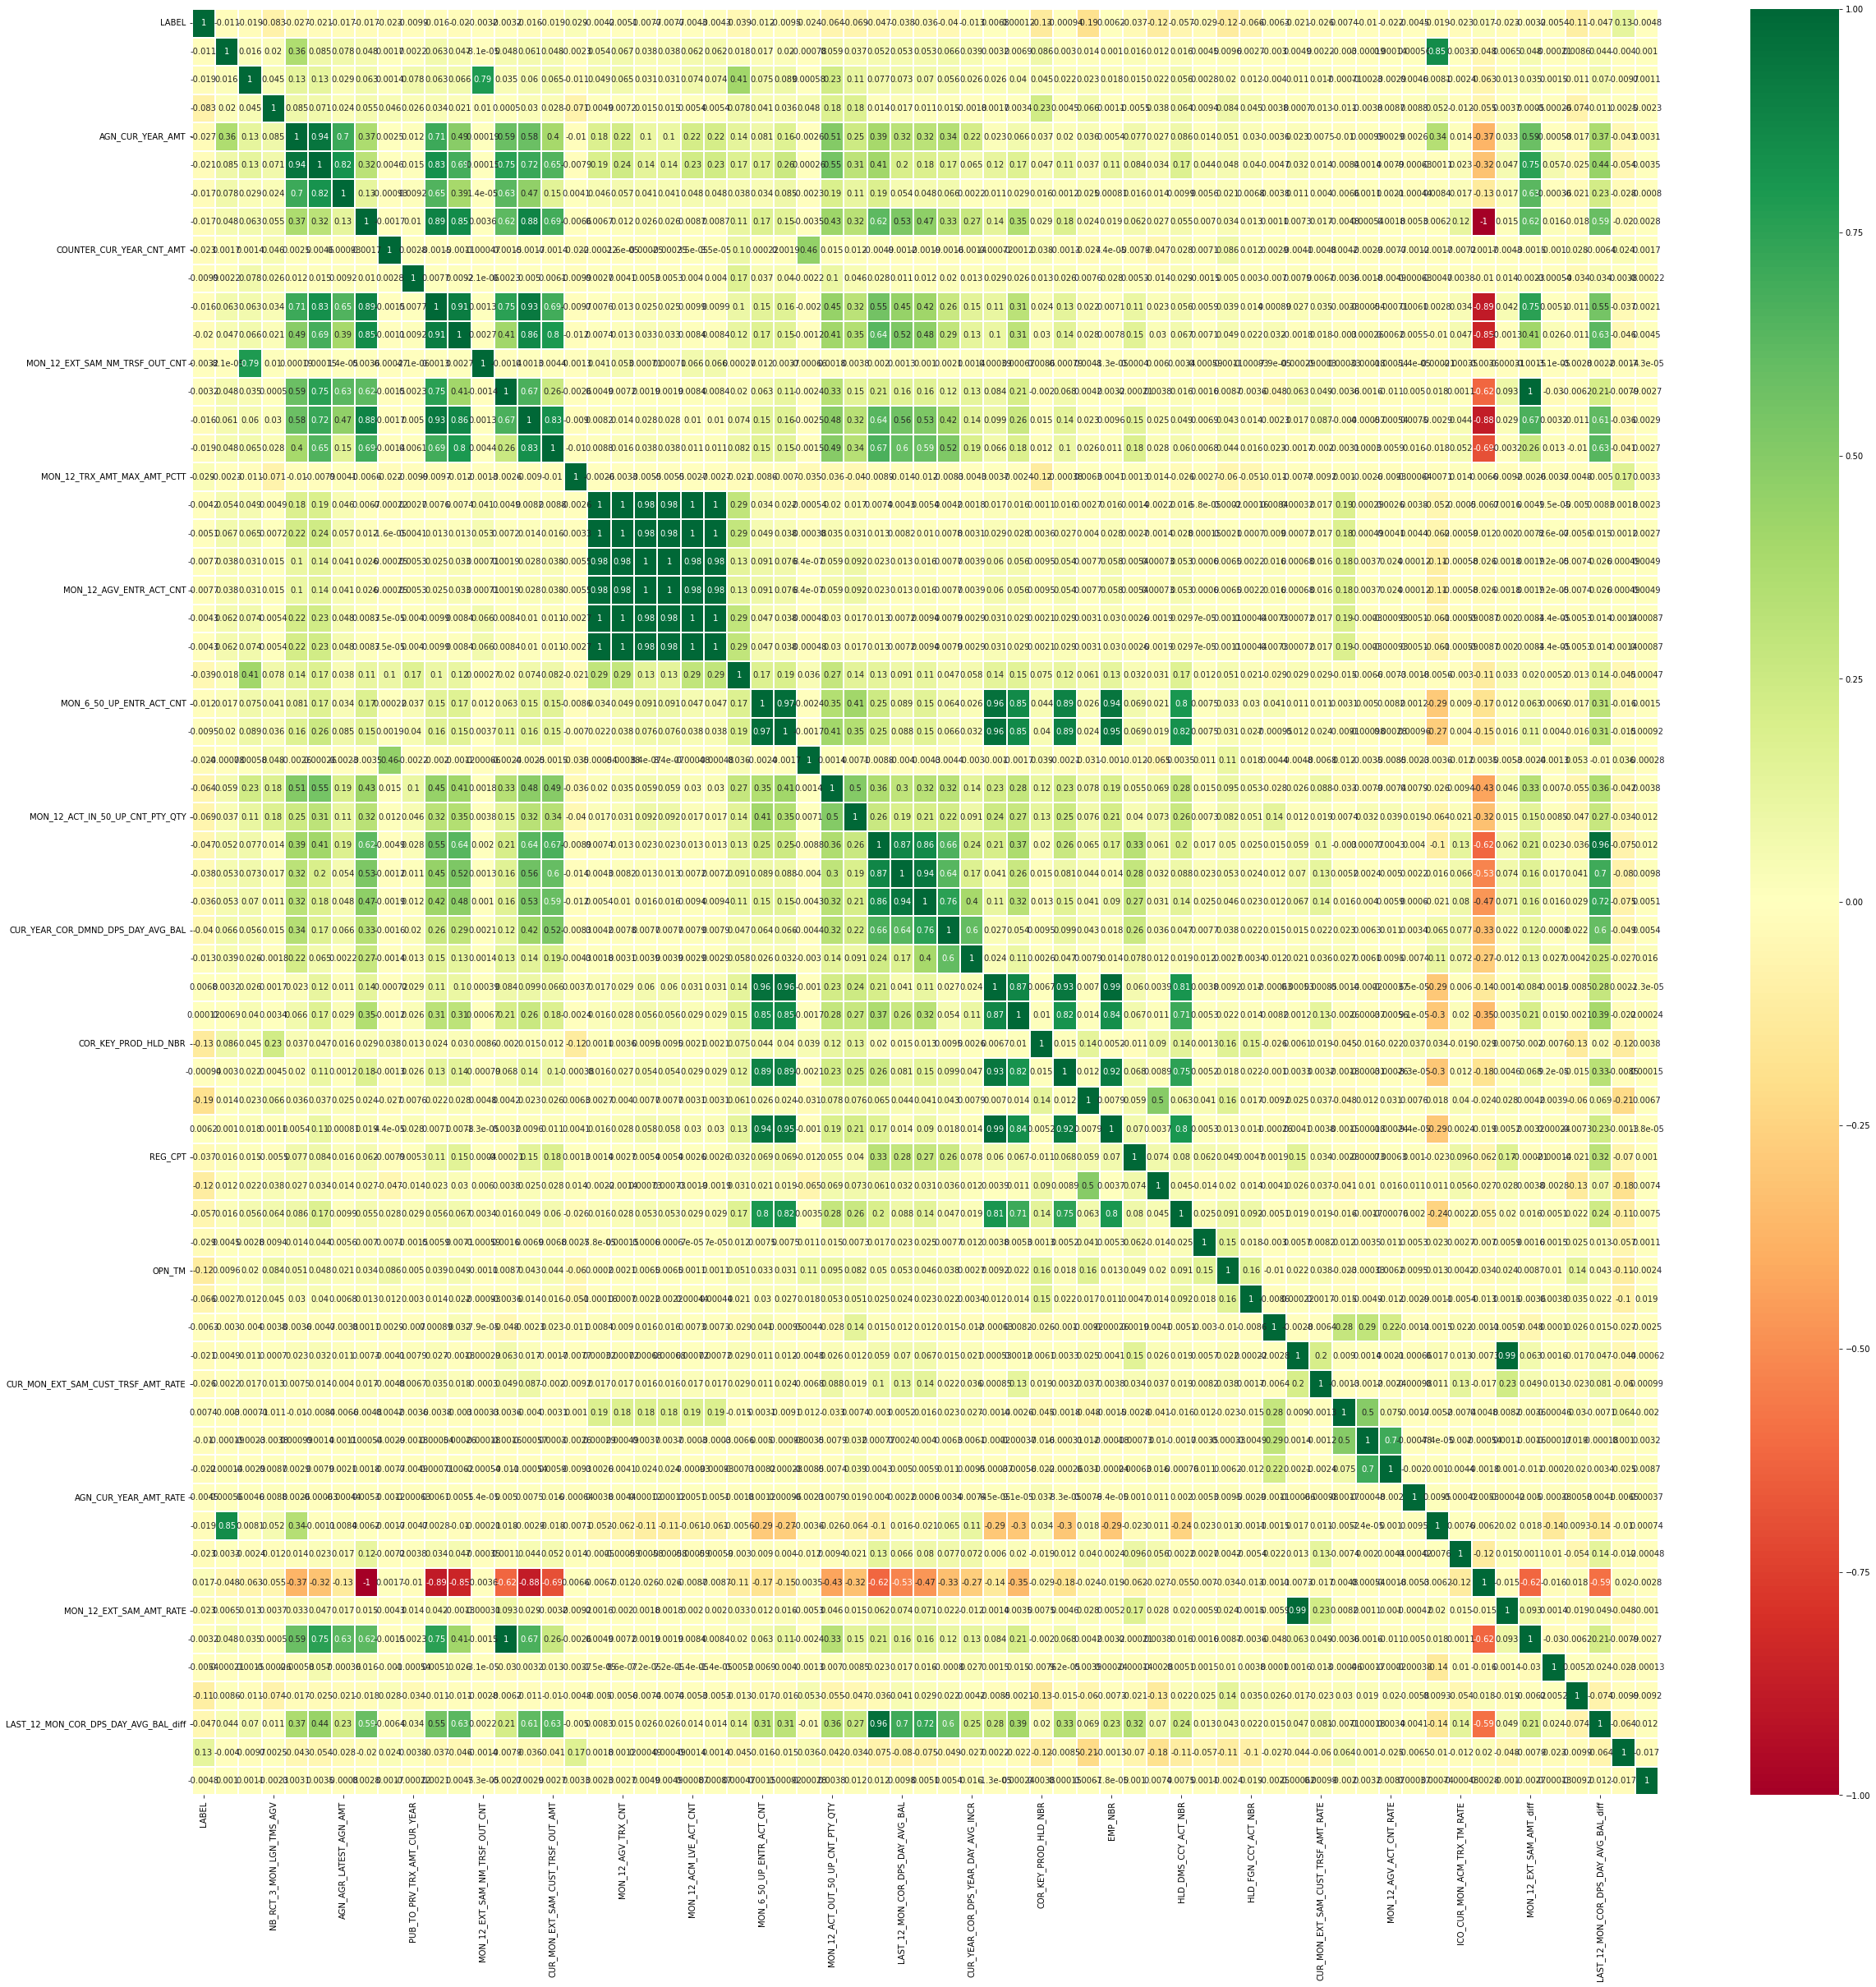

In [135]:
sns.heatmap(train[list(train.columns)].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(40,40)
plt.show()

In [142]:
#不做数量显示限制
# pd.options.display.max_rows=None#Notebook 的一个cell的显示行数
# pd.options.display.max_columns=None#Notebook 的一个cell的显示列数
print(list(train.columns)[:21])
print(list(train.columns)[21:41])
print(list(train.columns)[41:])

['CUST_UID', 'LABEL', 'AGN_CNT_RCT_12_MON', 'ICO_CUR_MON_ACM_TRX_TM', 'NB_RCT_3_MON_LGN_TMS_AGV', 'AGN_CUR_YEAR_AMT', 'AGN_CUR_YEAR_WAG_AMT', 'AGN_AGR_LATEST_AGN_AMT', 'ICO_CUR_MON_ACM_TRX_AMT', 'COUNTER_CUR_YEAR_CNT_AMT', 'PUB_TO_PRV_TRX_AMT_CUR_YEAR', 'MON_12_EXT_SAM_TRSF_IN_AMT', 'MON_12_EXT_SAM_TRSF_OUT_AMT', 'MON_12_EXT_SAM_NM_TRSF_OUT_CNT', 'MON_12_EXT_SAM_AMT', 'CUR_MON_EXT_SAM_CUST_TRSF_IN_AMT', 'CUR_MON_EXT_SAM_CUST_TRSF_OUT_AMT', 'MON_12_CUST_CNT_PTY_ID', 'MON_12_TRX_AMT_MAX_AMT_PCTT', 'CUR_YEAR_MON_AGV_TRX_CNT', 'MON_12_AGV_TRX_CNT']
['MON_12_ACM_ENTR_ACT_CNT', 'MON_12_AGV_ENTR_ACT_CNT', 'MON_12_ACM_LVE_ACT_CNT', 'MON_12_AGV_LVE_ACT_CNT', 'CUR_YEAR_PUB_TO_PRV_TRX_PTY_CNT', 'MON_6_50_UP_ENTR_ACT_CNT', 'MON_6_50_UP_LVE_ACT_CNT', 'CUR_YEAR_COUNTER_ENCASH_CNT', 'MON_12_ACT_OUT_50_UP_CNT_PTY_QTY', 'MON_12_ACT_IN_50_UP_CNT_PTY_QTY', 'LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL', 'LAST_12_MON_COR_DPS_DAY_AVG_BAL', 'CUR_MON_COR_DPS_MON_DAY_AVG_BAL', 'CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL', 

 12%|█▏        | 6/49 [00:00<00:00, 59.08it/s]

44


100%|██████████| 49/49 [00:00<00:00, 77.51it/s]

132


In [173]:
print(history_data)

[None]


<AxesSubplot:>

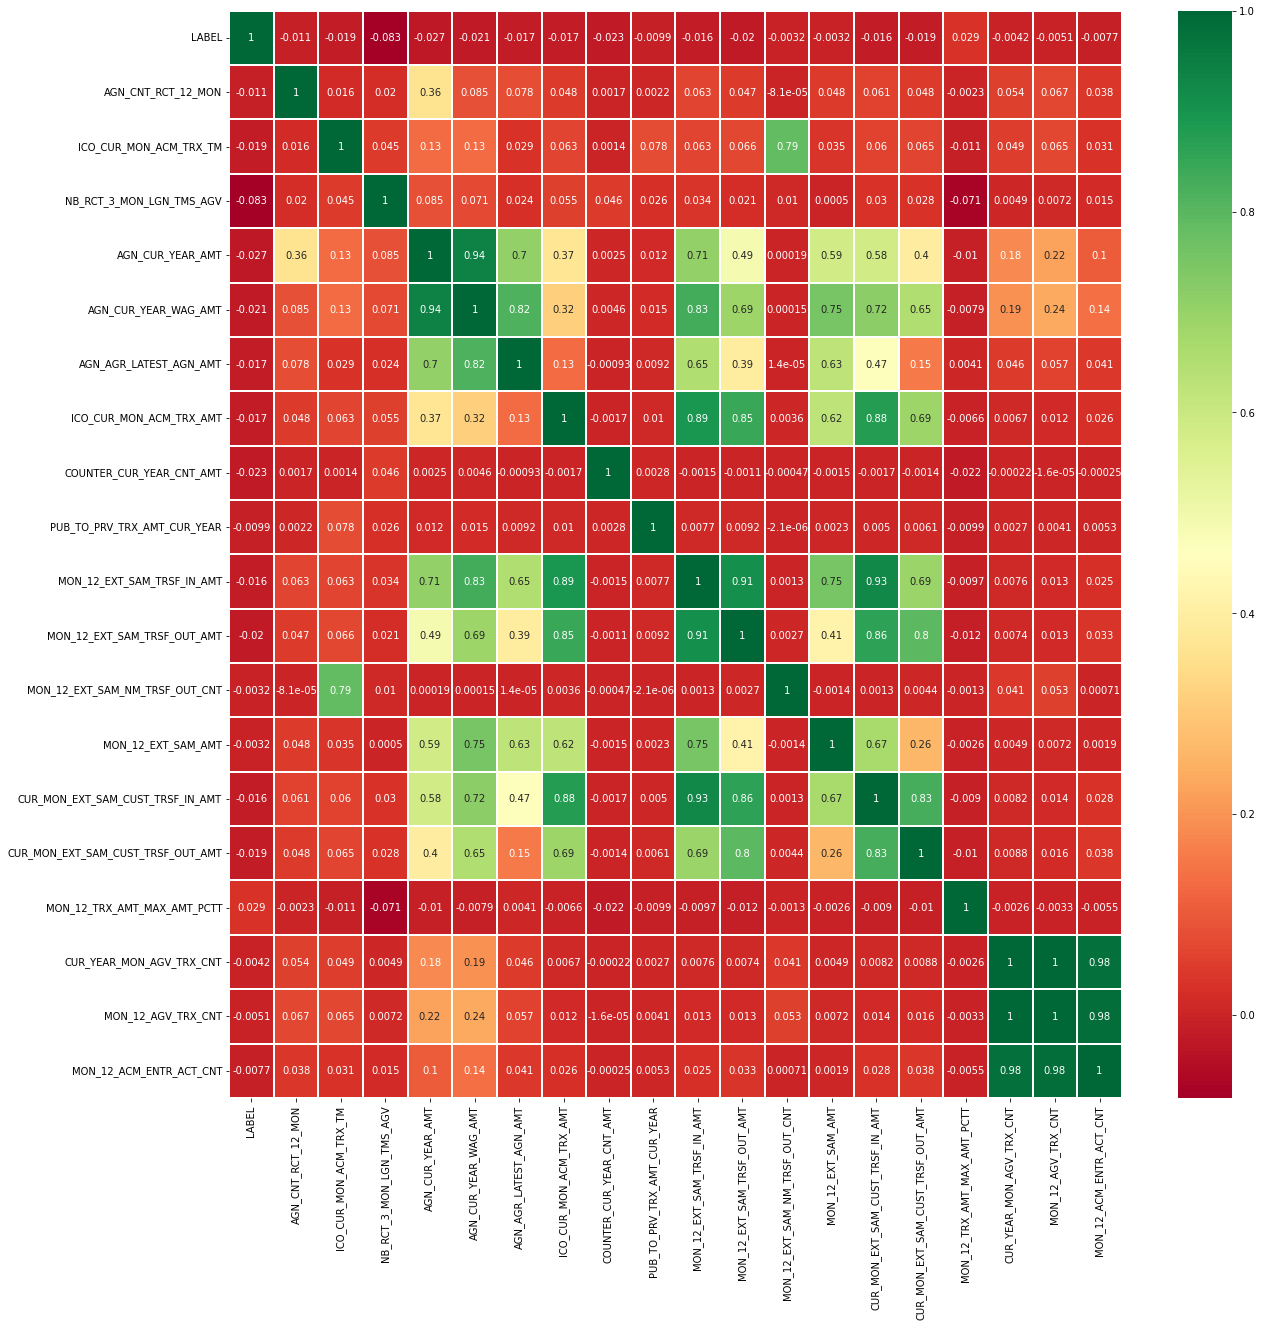

In [144]:
sns.heatmap(train[list(train.columns)[:22]].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [178]:
len(train.columns)

315